In [1]:
# Dependencias Generales
import os
import gc
import nibabel as nib
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Dependencias de PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split

# Dependencias de Fastai
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.data.load import DataLoader
from fastai.vision.models import resnet34
from fastai.losses import L1LossFlat # MAE Loss for flatten (lineal)
from fastai.metrics import mae, BalancedAccuracy, accuracy
from fastai.test_utils import *
from fastai.vision.all import *

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [2]:
# Fijar la semilla de PyTorch
torch.manual_seed(42)

# Fijar la semilla de NumPy
np.random.seed(42)

### Preparación del encoder.

In [3]:
# Leer los dataFrames con las rutas y los datos
train = pd.read_csv('/kaggle/input/partition/trainAtlas.csv')
valid = pd.read_csv('/kaggle/input/partition/validAtlas.csv')
test = pd.read_csv('/kaggle/input/partition/testAtlas.csv')

In [4]:
standard_normalize = lambda array: (array - np.mean(array)) / np.std(array) if np.std(array) != 0 else array - np.mean(array)

In [5]:
class BraTS(Dataset):
  """
    Permite la lectura de los datos y etiquetas.
    Combina ambos para formar un tensor el cual va a ser pasado a un dataloader.
  """
  def __init__(self, atlas, transform=None):
    """
      Constructor de la clase dataset.

      Args:
      atlas (DataFrame): Frame de datos que contiene las rutas a cada ejemplo, el nº de slice y su etiqueta.
      transform (bool, optional): Aplicar transformaciones a las imágenes. Por defecto, no.

    """
    super(BraTS, self).__init__()
    self.atlas = atlas
    self.transform = transform
    self.mri_dtype = torch.float32

  def __len__(self):
    """
      Devuelve el tamaño del dataset
    """
    return len(self.atlas)

  def __getitem__(self, index):

    """
     Devuelve un elemento del dataset

    """
    
    # Obtener los paths de cada imagen
    img_paths = self.atlas.iloc[index][['ruta_t1c', 'ruta_t1n', 'ruta_t2f']].tolist()
    slice_num = self.atlas.iloc[index]['slice']

    # Obtener las imágenes de cada prueba 
    X = np.zeros((240, 240, 3))
    for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 4 pruebas en 4 canales
      current_img = nib.load(img_path).dataobj[..., slice_num]       
      X[:, :, idx] += standard_normalize(current_img)
        
    x = torch.from_numpy(X.T).type(self.mri_dtype)
    y = torch.from_numpy(X.T).type(self.mri_dtype)
    
    del X
    del current_img

    return x, y

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.sequence(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.sequence(x)
    
class UpConvResize(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvResize, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=8, stride=1)
        )

    def forward(self, x):
        return self.block(x)

In [7]:
class ResidualAutoencoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(ResidualAutoencoder, self).__init__()
        
        self.encoder = nn.ModuleList([
            *list(resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).children())[:-2] # Tomar todas las capas excepto las últimas dos (avgpool y fc)
        ]) 

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder = nn.ModuleList([
            UpConvResize(1024, 512), #15
            UpConv(512, 256), #30
            UpConv(256, 128), #60
            UpConv(128, 64), #120
        ])
        
        self.output = nn.Sequential(
            UpConv(64, 32),
            nn.Conv2d(32, out_channels, kernel_size=1),
        )      
        
    def forward(self, x):
        # skips = []
        o = x
            
        for layer in self.encoder:
            o = layer(o)
            # skips.append(o)

        o = self.bottleneck(o)

        for layer in self.decoder:
            # o = torch.cat((skips[len(skips)-i-1],o), dim=1)
            o = layer(o)
            
        for layer in self.output:
            o = layer(o) 
            
        return o

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_BS = BraTS(train)
valid_BS = BraTS(valid)

train_dl = DataLoader(train_BS, batch_size=32, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_BS, batch_size=32, pin_memory=True)

autoencoder = ResidualAutoencoder().to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 149MB/s] 


In [9]:
# Crear el objeto Learner
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(
    dls=dls,  
    model=autoencoder,      
    loss_func=L1LossFlat(),    
    metrics=[mae]
)

print(learn.summary())

ResidualAutoencoder (Input shape: 32 x 3 x 240 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 120 x 120 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 60 x 60   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU             

In [10]:
model_path = Path('/kaggle/input/encoder2/fittingautoencodertotrain')

# Cargar los pesos
learn.load(model_path)

## Clasificando entre Gliomas y Meningiomas

#### Redefinición de la clase de Dataset

In [11]:
class BraTS_BIN(Dataset):
  """
    Permite la lectura de los datos y etiquetas.
    Combina ambos para formar un tensor el cual va a ser pasado a un dataloader.
  """
  def __init__(self, atlas, transform=None):
    """
      Constructor de la clase dataset.

      Args:
      atlas (DataFrame): Frame de datos que contiene las rutas a cada ejemplo, el nº de slice y su etiqueta.
      transform (bool, optional): Aplicar transformaciones a las imágenes. Por defecto, no.

    """
    super(BraTS_BIN, self).__init__()
    self.atlas = atlas
    self.transform = transform
    self.mri_dtype = torch.float32
    self.label_dtype = torch.float32

  def __len__(self):
    """
      Devuelve el tamaño del dataset
    """
    return len(self.atlas)

  def __getitem__(self, index):

    """
     Devuelve un elemento del dataset

    """
    
    # Obtener los path de cada imagen
    img_paths = self.atlas.iloc[index][['ruta_t1c', 'ruta_t1n', 'ruta_t2f']].tolist()
    label = self.atlas.iloc[index]['etiqueta']
    slice_num = self.atlas.iloc[index]['slice']

    brain_img = np.zeros((240, 240, 3))
    
    for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 3 pruebas
      current_img = nib.load(img_path).dataobj[..., slice_num]  
      brain_img[:, :, idx] += standard_normalize(current_img)
        
    x = torch.from_numpy(brain_img.T).type(self.mri_dtype)
    y = torch.tensor(label, dtype=torch.long)

    del brain_img
    del current_img

    return x, y

In [12]:
class BinaryNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, encoder_model=None):
        super(BinaryNet, self).__init__()
        
        # Encoder
        self.encoder = encoder_model.encoder
        
        # Representación latente
        self.bottleneck = encoder_model.bottleneck
        
        self.flatten = nn.Flatten()
        
        # Capas densamente conectadas
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 8 * 8, 512),  # Capa lineal con 1024*8*8 entradas y 512 salidas
            nn.ReLU(),
            nn.Linear(512, 256),            # Capa lineal con 512 entradas y 256 salidas
            nn.ReLU(),
            nn.Linear(256, 128),            # Capa lineal con 256 entradas y 128 salidas
            nn.ReLU(),
            nn.Linear(128, 3)              # Capa lineal con 128 entradas y 3 salidas
        )
        
    def forward(self, x):
        o = x
            
        for layer in self.encoder:
            o = layer(o)

        o = self.bottleneck(o)
        o = self.flatten(o)
        o = self.classifier(o)
            
        return o

In [13]:
train_BIN = BraTS_BIN(train)
valid_BIN = BraTS_BIN(valid)

train_dl = DataLoader(train_BIN, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_BIN, batch_size=32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
binary_net = BinaryNet(encoder_model = learn.model).to(device)

In [14]:
# Crear el objeto Learner
balancedAccuracy = BalancedAccuracy()

dls = DataLoaders(train_dl, valid_dl)
learn_bin = Learner(
    dls=dls,  
    model=binary_net,      
    loss_func=FocalLossFlat(),    
    metrics=[accuracy, balancedAccuracy]
)

print(learn_bin.summary())

BinaryNet (Input shape: 32 x 3 x 240 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 120 x 120 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 60 x 60   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                       

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.112794,0.178968,0.805254,0.781898,1:04:50
1,0.119699,0.174729,0.819330,0.773066,1:03:01
2,0.083459,0.141255,0.855540,0.794527,1:04:18


Better model found at epoch 0 with valid_loss value: 0.1789679229259491.


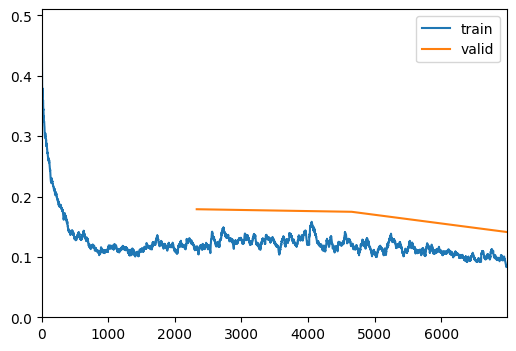

Better model found at epoch 1 with valid_loss value: 0.1747288852930069.
Better model found at epoch 2 with valid_loss value: 0.14125469326972961.


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.056434,0.209338,0.855477,0.840139,1:01:57
1,0.040761,0.190361,0.864976,0.812309,1:01:41
2,0.023256,0.260177,0.876575,0.832247,1:00:26
3,0.009723,0.330192,0.877014,0.834721,1:00:30


Better model found at epoch 0 with valid_loss value: 0.20933781564235687.


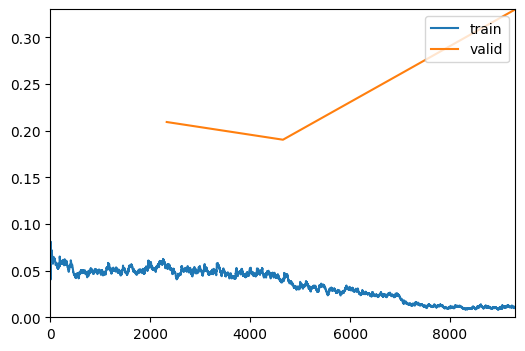

Better model found at epoch 1 with valid_loss value: 0.19036060571670532.


In [15]:
cbs = [SaveModelCallback(), ShowGraphCallback(), EarlyStoppingCallback(monitor='valid_loss', patience=3)]

# Entrenar toda la red
learn_bin.fine_tune(epochs = 4, freeze_epochs = 3, cbs=cbs)

#### Curva de entrenamiento obteniendo una imagen de cada resonancia por época

In [16]:
learn_bin.save('/kaggle/working/ternaryclassification')

Path('/kaggle/working/ternaryclassification.pth')

### Matrices de confusión

In [17]:
def matriz_confusion(preds, targets, conjunto='entrenamiento'):
    classes=['Meningioma', 'Glioma', 'No Tumor']
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Matriz de confusión para {conjunto}')
    plt.colorbar()

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()
    
    print(f'El accuracy balanceado en el conjunto de {conjunto} es:', balanced_accuracy_score(targets, preds))
    

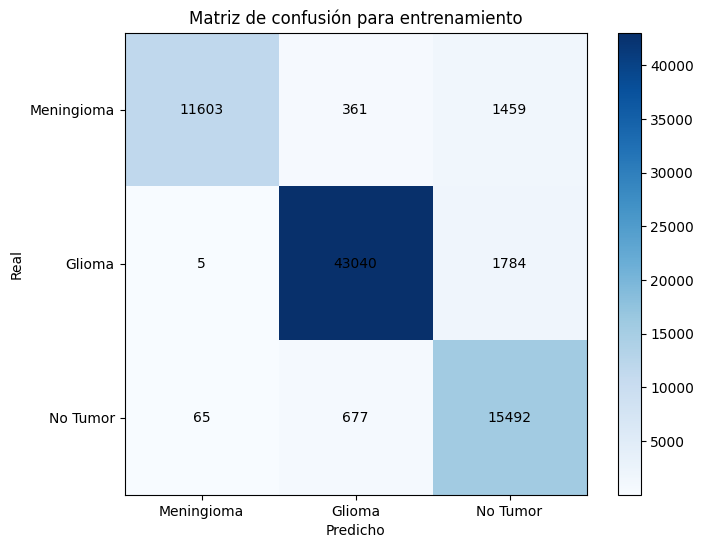

El accuracy balanceado en el conjunto de entrenamiento es: 0.9262660285626048


In [18]:
# Computamos la matriz de confusión
preds, targets = learn_bin.get_preds(dl=train_dl)
predicted = torch.argmax(preds, dim=1) # Transformar preds en un tensor de 0, 1 y 2.
matriz_confusion(predicted, targets)

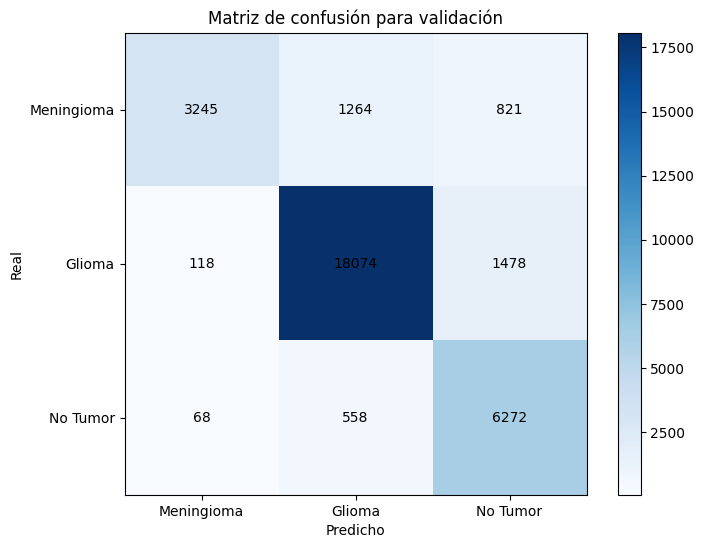

El accuracy balanceado en el conjunto de validación es: 0.8123094263064439


In [19]:
# Computamos la matriz de confusión
preds, targets = learn_bin.get_preds(dl=valid_dl)
predicted = torch.argmax(preds, dim=1) # Transformar preds en un tensor de 0, 1 y 2.
matriz_confusion(predicted, targets, conjunto='validación')

### Hacer votación con test